# Riskops as Oracles

## Thompson Sampling applied to Active Learning

# 1 -  Active Learning

# 2 - Contextual Multi-Armed Bandit

# 3 - Thompson Sampling

# 4 - (1+2+3) Active Thompson Sampling


# Passive Learning
    


Text(0.5,1,u'Cheddar Cheese price, wholesale')

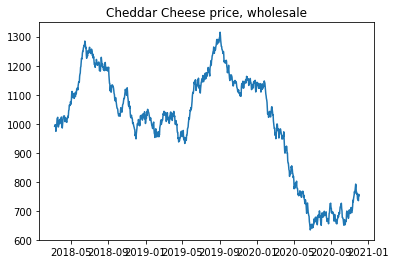

In [1]:
import matplotlib.pyplot as plt
import datetime
import pandas as pd
import numpy as np

%matplotlib inline

N_PERIODS = 1000
datelist = pd.date_range(pd.datetime.today(), periods=N_PERIODS).tolist()
price = 1000 + np.cumsum(np.random.normal(size=N_PERIODS, scale=10))
plt.plot(datelist, price)

plt.title('Cheddar Cheese price, wholesale')


# Active Learning

![](https://cdn.pixabay.com/photo/2012/03/03/23/56/fly-21685_960_720.jpg)

# Let's catch some fraudsters!

In [2]:
import numpy as np
from sklearn.datasets import fetch_lfw_people

In [3]:
lfw_people = fetch_lfw_people(min_faces_per_person=200, resize=.8)

In [4]:
n_samples, h, w = lfw_people.images.shape

In [5]:
X = lfw_people.data
n_features = X.shape[1]

In [6]:
# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

In [7]:
import matplotlib.pyplot as plt

def plot_gallery(image, title, h, w):
    """Helper function to plot a gallery of portraits"""
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    plt.imshow(image.reshape((h, w)), cmap=plt.cm.gray)
    plt.title(title, size=12)
    plt.xticks(())
    plt.yticks(())

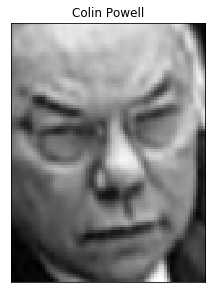

In [8]:
plot_gallery(X[y==0][0], target_names[0], h, w)

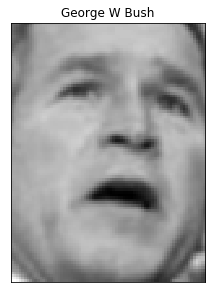

In [9]:
plot_gallery(X[y==1][0], target_names[1], h, w)

In [10]:
from sklearn.decomposition import PCA

In [11]:
pca_all =  PCA(n_components=2).fit(X)

In [12]:
pca = pca_all.transform(X)

In [13]:
pca_df = pd.DataFrame(pca)
pca_df['y'] = [target_names[i] for i in y ]

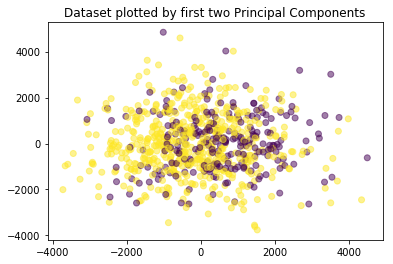

In [14]:
plt.scatter([x[0] for x in pca], [x[1] for x in pca], marker='o', c=y, alpha=.5)
plt.title('Dataset plotted by first two Principal Components')
plt.show()

Now, using an active learning context

In [15]:
from sklearn.model_selection import train_test_split

In [32]:
# split into a training and testing set
X_train, X_test, y_train, y_test, indices_train,indices_test = \
train_test_split(X, y, np.arange(X.shape[0]), test_size=0.95, random_state=42)

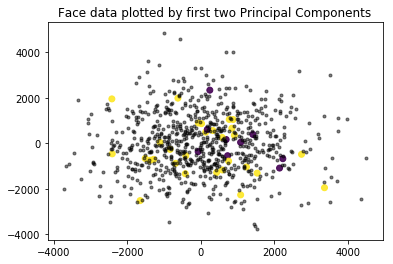

In [34]:
plt.scatter([x[0] for x in pca[indices_train]], [x[1] for x in pca[indices_train]],
            marker='o',
            c=y_train, alpha=.9)
plt.scatter([x[0] for x in pca[indices_test]], [x[1] for x in pca[indices_test]],
            marker='.', c='black', alpha=.5)
plt.title('Face data plotted by first two Principal Components')
plt.show()

# Performance of random sampling for active learning

In [19]:
from sklearn.linear_model import  LogisticRegression

In [20]:
perc_iterations = np.arange(.05, .6, .05)

In [21]:
perc_iterations

array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55])

In [22]:
perc_iterations = np.arange(.05, .5, .05)
n_iteration = [int(f) for f in  perc_iterations * X.shape[0]]

In [38]:
np.mean(y)

0.6919060052219321

NameError: name 'matplotlib' is not defined

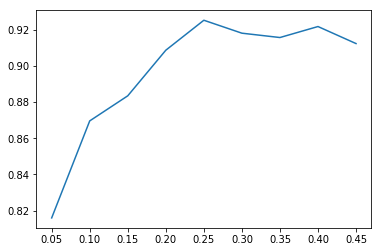

In [40]:
score_random_sampling = []
for i in n_iteration:
    X_train = X[:i]
    y_train = y[:i]
    lr = LogisticRegression(random_state=633).fit(X_train, y_train)
    score_random_sampling.append(lr.score(X[i:], y[i:]) )

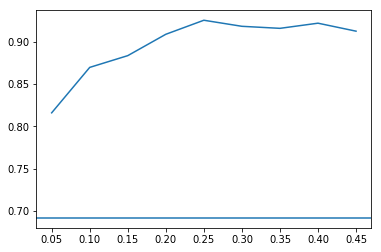

In [41]:
%matplotlib inline
plt.plot(perc_iterations, score_random_sampling)
plt.axhline(y=np.mean(y))

Performance of Uncertainty Labeling

In [24]:
initial_batch = range(n_iteration[0])
index_labeled = np.zeros(len(X), np.bool)
index_labeled[initial_batch] = 1

In [25]:
# Uncertainty sampling
score_uncertainty_sampling = []
N_ROUNDS = 100

for i in range(N_ROUNDS):
    # train and scoreq
    X_train_us = X[index_labeled]
    y_train_us = y[index_labeled]
    lr = LogisticRegression(random_state=633).fit(X_train_us, y_train_us)
    score_uncertainty_sampling.append(lr.score(X[~index_labeled], y[~index_labeled]))
    
    # In unlabelled group, find most uncertain prediction:
    fitted, fitted_index = lr.predict_proba(X[~index_labeled]), np.arange(len(X))[~index_labeled]
    most_uncertain_index_in_test = np.argmin(abs(.5 - fitted[:,1]))
    most_uncertain_index_in_global = fitted_index[most_uncertain_index_in_test]
    # add the most uncertain point to the dataset
    index_labeled[most_uncertain_index_in_global] = 1

In [26]:
assert score_random_sampling[0] == score_uncertainty_sampling[0]

In [27]:
# Translate N points labeled in % points labeled
perc_iterations_us = np.arange(n_iteration[0], n_iteration[0]+N_ROUNDS, 1) * 1. / len(X) 

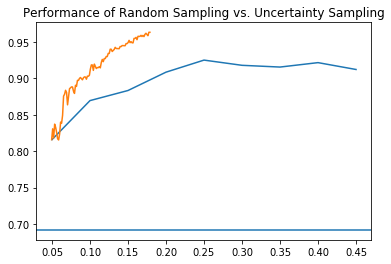

In [42]:
%matplotlib inline
plt.plot(perc_iterations, score_random_sampling)
plt.plot(perc_iterations_us, score_uncertainty_sampling)
plt.title('Performance of Random Sampling vs. Uncertainty Sampling')
plt.axhline(y=np.mean(y))
plt.show()

# Multiarmed bandit

slot machines that all look the same


Implement epsilon greedy algorithm

# Thompson Sampling

Implement Thompson sampling algorithm

# Contextual Multiarmed Bandit

(slot machines that are slightly different)